# Predict TripAdvisor Rating

**Основная цель:** Предсказать рейтинг ресторанов на Tripadvisor (c MAE выше базовой модели 0.21).

*Best Models на Kaggle MAE < 0.14*

# Import libraries & dataset

In [1]:
import time
from datetime import datetime  # работа с датой и временем
import re  # работа с регулярными выражениями
import os
import json
from collections import Counter
import itertools
import datetime as dt
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder  # переименование заголовков
from sklearn import metrics  # инструменты для оценки точности модели
# специальный инструмент для разбивки
from sklearn.model_selection import train_test_split
import numpy as np  # linear algebra
import pandas as pd  # data processing

# для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

for dirname, _, filenames in os.walk('C:/Users/rf110933/Desktop/Education/ML/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/Users/rf110933/Desktop/Education/ML/kaggle/input\kaggle_task.csv
C:/Users/rf110933/Desktop/Education/ML/kaggle/input\main_task.csv
C:/Users/rf110933/Desktop/Education/ML/kaggle/input\sample_submission.csv


In [2]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 50

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA SET UPLOAD & FIRST REVIEW

In [4]:
DATA_DIR = 'C:/Users/rf110933/Desktop/Education/ML/kaggle/input'
# прогружаем тренировочный data set
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
# прогружаем тестовый data set
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
# Путь к датасету, содержащему позитивные слова
df_pos_words = pd.read_csv('positive-words.txt', skiprows=34, names=['word'])
pos_words_list = df_pos_words['word'].to_list()

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [10]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [12]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [13]:
# Посмотрим на общую информацию о данных и количество пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


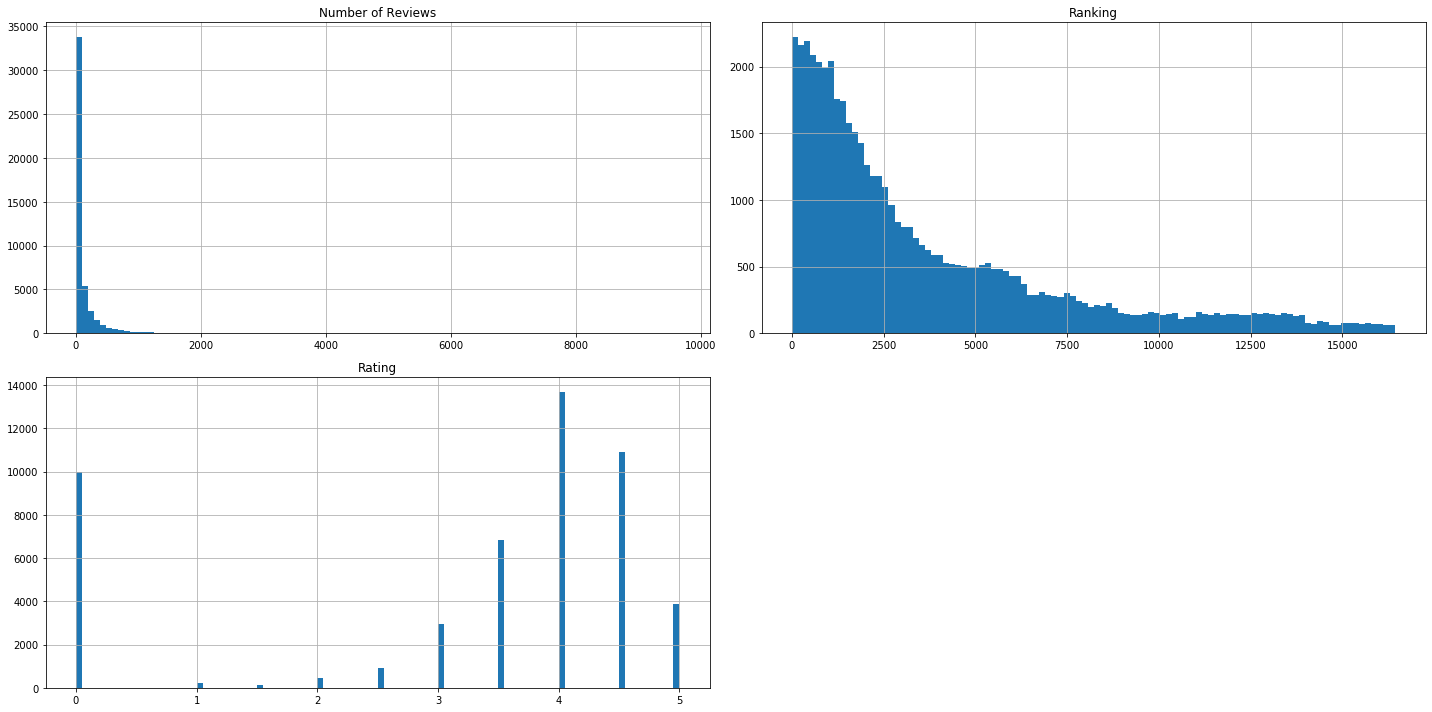

In [14]:
# Посмотрим на гистограмму числовых переменных
data[['Ranking', 'Number of Reviews', 'Rating']].hist(
    figsize=(20, 10), bins=100)
plt.tight_layout()

In [15]:
# Посмотрим на количество уникальных значений
data.nunique(dropna=False)

Restaurant_id        13094
City                    31
Cuisine Style        10732
Ranking              12975
Price Range              4
Number of Reviews     1574
Reviews              41858
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
dtype: int64

Мы видим, что большинство признаков требует очистки и предварительной обработки - есть пропуски, номинативные переменные в странном формате. Данные необходимо будет очистить и привести в порядок.

**Признаки**:
* Restaurant_id: идентификационный номер ресторана; 
* City: Город;
* Cuisine Style: Кухня;
* Ranking: Ранг ресторана относительно других ресторанов в этом городе;
* **Rating**: Рейтинг ресторана (именно это значение должна будет предсказывать модель);
* Price Range: Цены в ресторане в 3 категориях;
* Number of Reviews: Количество отзывов;
* Reviews: 2 последних отзыва и даты этих отзывов;
* URL_TA: страница ресторана на 'www.tripadvisor.com';
* ID_TA: ID ресторана в TripAdvisor;

In [16]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
48371,id_8623,Paris,['French'],8625.0,NaN,4.0,"[['Amazing food and good prices!', 'Simple lun...",/Restaurant_Review-g187147-d10166205-Reviews-B...,d10166205,1,4.5
41787,id_236,Dublin,"['Irish', 'Bar', 'Pub']",237.0,$$ - $$$,459.0,"[['Very interesting place.', 'Good beer select...",/Restaurant_Review-g186605-d696358-Reviews-Ble...,d696358,1,4.0
14818,id_194,Krakow,"['Polish', 'Bar', 'European', 'Pub', 'Vegetari...",195.0,$$ - $$$,199.0,"[['Stopped for a drink, very happy', 'Interest...",/Restaurant_Review-g274772-d6405345-Reviews-Fo...,d6405345,1,4.0
41612,id_2238,London,"['French', 'Fast Food']",2243.0,$$ - $$$,150.0,"[['Very good', 'Great Tasting Burger, pity abo...",/Restaurant_Review-g186338-d7812716-Reviews-Bi...,d7812716,1,4.0
3504,id_3504,London,"['Italian', 'Pizza', 'European', 'Vegetarian F...",1228.0,$$ - $$$,230.0,"[['A real taste of Italy', 'Puglia!'], ['12/22...",/Restaurant_Review-g186338-d1127947-Reviews-Ha...,d1127947,0,0.0


In [17]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

# Cleaning and Prepping Data incl. FE

Большинство признаков требует очистки и предварительной обработки:
* Необходимо будет избавиться от пустых ячеек в Cuisine Style, Price Range, Number of Reviews, Reviews
* Привести в порядок данные с номинативными переменными
* Номинативные переменные сделать числовыми
* Сделать доп группировки

## City

In [18]:
# Посмотрим сколько у нас городов и много ли значений у каждого из городов
data.City.nunique()

31

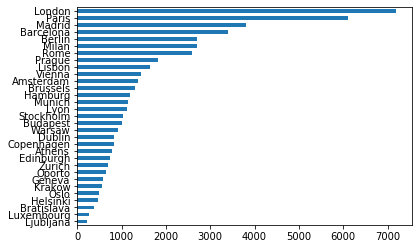

In [19]:
data['City'].value_counts(ascending=True).plot(kind='barh')

In [20]:
data['City'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

Из графика видно, что в основном рестораны сосредоточены в крупных городах, в то время, как в маленьких выборка становится не репрезентативной, поэтому имеет смысл группировать их, например, по странам.

In [21]:
# Справочник город-страна:
city_country = {
    'London': 'UK',
    'Paris': 'France',
    'Madrid': 'Spain',
    'Barcelona': 'Spain',
    'Berlin': 'Germany',
    'Milan': 'Italy',
    'Rome': 'Italy',
    'Prague': 'Czech',
    'Lisbon': 'Portugal',
    'Vienna': 'Austria',
    'Amsterdam': 'Netherlands',
    'Brussels': 'Belgium',
    'Hamburg': 'Germany',
    'Munich': 'Germany',
    'Lyon': 'France',
    'Stockholm': 'Sweden',
    'Budapest': 'Hungary',
    'Warsaw': 'Poland',
    'Dublin': 'Ireland',
    'Copenhagen': 'Denmark',
    'Athens': 'Greece',
    'Edinburgh': 'Scotland',
    'Zurich': 'Switzerland',
    'Oporto': 'Portugal',
    'Geneva': 'Switzerland',
    'Krakow': 'Poland',
    'Oslo': 'Norway',
    'Helsinki': 'Finland',
    'Bratislava': 'Slovakia',
    'Luxembourg': 'Luxembourg',
    'Ljubljana': 'Slovenia'
}

# Создаем столбец с названием страны и трансформируем его в числовой:
data['Country'] = data['City'].map(city_country)

le = LabelEncoder()
le.fit(data['Country'])
data['Country Code'] = le.transform(data['Country'])

# Трансформируем город в числовой вид:
le.fit(data['City'])
data['City Code'] = le.transform(data['City'])

In [22]:
# Создаем dummy переменную "Capital"
capitals = [
    'London', 'Paris', 'Madrid', 'Berlin', 'Rome', 'Prague', 'Lisbon',
    'Vienna', 'Amsterdam', 'Brussels', 'Stockholm', 'Budapest', 'Warsaw',
    'Dublin', 'Copenhagen', 'Athens', 'Edinburgh', 'Oslo', 'Helsinki', 'Bratislava',
    'Luxembourg', 'Ljubljana'
]
data['Capital'] = data['City'].apply(lambda x: 1 if x in capitals else 0)

In [23]:
# Новая фича количество ресторанов на город "Rest per City"
data['Rest per City'] = data['City'].map(
    data.groupby(['City'])['Restaurant_id'].count().to_dict())

In [24]:
# Новая фича количество ресторанов на душу населения "Rest per capita"
population = {
    'Paris': 2148271,
    'Stockholm': 975904,
    'London': 8908081,
    'Berlin': 3769495,
    'Munich': 1456039,
    'Oporto': 237559,
    'Milan': 3140181,
    'Bratislava': 434926,
    'Vienna': 1929944,
    'Rome': 4257056,
    'Barcelona': 5585556,
    'Madrid': 6617513,
    'Dublin': 1228179,
    'Brussels': 2080788,
    'Zurich': 1395356,
    'Warsaw': 1783251,
    'Budapest': 1768073,
    'Copenhagen': 1346485,
    'Amsterdam': 1148972,
    'Lyon': 1719268,
    'Hamburg': 1789954,
    'Lisbon': 2956879,
    'Prague': 1305737,
    'Oslo': 1041377,
    'Helsinki': 1304851,
    'Edinburgh': 536775,
    'Geneva': 613373,
    'Ljubljana': 288307,
    'Athens': 3153355,
    'Luxembourg': 628408,
    'Krakow': 768731
}

data['Population'] = data['City'].map(population)
data['Rest per Capita'] = data['Rest per City'] / data['Population']

## Cuisine Style

In [25]:
data['Cuisine Style'].value_counts()  # посмотрим на данные по кухням

['Italian']                                                                                                                1332
['French']                                                                                                                 1019
['Spanish']                                                                                                                 860
['French', 'European']                                                                                                      503
['Cafe']                                                                                                                    500
                                                                                                                           ... 
['Mexican', 'Bar', 'Pub', 'Street Food']                                                                                      1
['Indian', 'Pizza', 'Barbecue', 'Halal', 'Vegetarian Friendly']                                         

Данные смешанные, надо их структурировать, посчитать количество типов кухни, и заменить NaN.
Для этого воспользуемся рядом функций.

In [26]:
# Делаем список из кухонь и заменой NaN на региональную кухню.
def get_cuisines(cuisines):
    if cuisines == 'NaN':
        return ['Regional Cusine']
    if cuisines:
        cuisines = str(cuisines).replace("'", '"')
        return json.loads(cuisines)
    else:
        return ['Regional Cusine']


# Считаем количество кухонь
allCusines = []


def cuisine_styles_count(row):
    global allCusines
    cusines = get_cuisines(row['Cuisine Style'])
    if row['Cuisine Style'] != 'NaN':
        cusines = get_cuisines(row['Cuisine Style'])
        allCusines.extend(cusines)
        cuisines_count = len(cusines)
    else:
        cuisines_count = 1
    return cuisines_count

In [27]:
# Избавимся от пропусков
data['Cuisine Style'] = data['Cuisine Style'].fillna('NaN')

# Посчитаем количество кухонь в каждом ресторане
data['Cuisines Count'] = data.apply(cuisine_styles_count, axis=1)

In [28]:
# Найдем наиболее популярную кухню и среднее количество кухонь в каждом ресторане
most_popular_cusine = pd.Series(allCusines).value_counts().index[0]
average_cousines_count = np.round(data['Cuisines Count'].mean())

In [29]:
# Проставим маркировку 1/0 есть ли в ресторане самая популярная кухня (isMostPopCusine) и насколько там больше кухонь vs average (isMultyCusine)
data['isMostPopCusine'] = data['Cuisine Style'].apply(
    lambda x: 1 if most_popular_cusine in x else 0)
data['isMultyCusine'] = data['Cuisines Count'].apply(
    lambda x: 1 if x >= average_cousines_count else 0)

In [30]:
# Посчитаем количество кухонь в каждом городе
cusines_in_city = {}
cusines_count_in_city = {}
for city_name, group in data.groupby('City'):

    cusines = group['Cuisine Style'].apply(get_cuisines)

    cusines_list = list(itertools.chain.from_iterable(cusines))
    cusines_in_city[city_name] = Counter(cusines_list)

for city_name in cusines_in_city.keys():
    cusines_count_in_city[city_name] = len(cusines_in_city[city_name])

data['Cusines Count In City'] = data['City'].map(cusines_count_in_city)

## Ranking

In [31]:
# Новая фича "Relative Ranking" - средневзевешенный на кол-во ресторанов в городе рэнкинг
data['Relative Ranking'] = data['Ranking'] / data['Rest per City']

## Rating

In [32]:
data['Rating'].value_counts()

4.0    13692
4.5    10929
0.0    10000
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: Rating, dtype: int64

In [33]:
# Функция оркугления рейтинга до 0.5 (понадобится в конце)
def round_of_rating(number):
    return np.round(number * 2) / 2

Мы видим, что у нашей главной целевой переменной много 0, что может ухудшить точность нашей модели. Но пока мы ничего с ней не делаем.

## Pricing

In [34]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

Мы видим, что цены варьируются в 3 диапазонах, которые легко можно оцифровать от 0 до 2, где 0 - самый дешевый ресторан и 2 - самый дорогой.
Также мы знаем, что у данной переменной есть пустые значения, которые мы заполним на среднее значение.

In [35]:
# Вводим dummy переменную "Price" вместо "Price Range" с заменой NaN на среднее:
price_range = {'$': 0, '$$ - $$$': 1, '$$$$': 2}
data['Price'] = data['Price Range'].map(price_range)
data['Price'].fillna(data['Price'].mean(), inplace=True)
del data['Price Range']

## Number of Reviews

In [36]:
# Заменяем пустоты в количестве просмотров средним.
data['Number of Reviews'].fillna(
    data['Number of Reviews'].mean(), inplace=True)

## Reviews

In [37]:
# Убираем NaN
data['Reviews'] = data['Reviews'].fillna('[[], []]')

# Новая фича "Reviews per a City" + заполнение пустот средним количеством
data['Reviews per City'] = data['Number of Reviews'].map(
    data.groupby(['Number of Reviews'])['Number of Reviews'].count().to_dict())

Мы знаем из части выше, что отзывы содержат в себе характеристику положительный/негативный-> можно присвоить тональность и дату. Нам нужно вытащить максимум информации из данного поля.
Начнем с написания функций, которые упростят нам жизнь.

In [38]:
# Добавляем переменные с текстом отзыва и датой
def get_reviews(rev):
    if not pd.isna(rev):
        rev = str(rev).replace("'", '"')
        rev = rev.replace('], [', '], "reviews_dt": [')
        rev = '{ "reviews_txt":' + rev + '}'
        rev = rev.replace('[[', '[').replace(']]', ']')
        d = json.loads(rev)
        d['reviews_dt'] = [dt.datetime.strptime(date, '%m/%d/%Y').date() if len(date.split(
            '/')[2]) == 4 else dt.datetime.strptime(date, '%m/%d/%y').date() for date in d['reviews_dt']]
        return d
    else:
        return {}

# Очищаем текст


def cleanup_string(str_in):
    try:
        str = str_in.replace("', \"", "⅞").replace(
            "', '", "⅞").replace("\", '", "⅞").replace("\", \"", "⅞")
        str = str.replace("\", \"\"", "⅞").replace(
            "\"\", '", "⅞").replace("\", \'", "⅞").replace("\"\", \'", "⅞")
        str = str.replace("\', \'", "⅞")

        str = str.replace("[['", "≤").replace("['", "⅛")

        str = str.replace("']]", "≥").replace("']", "⅝")

        str = str.replace('\'', ' ').replace(
            '\"', ' ').replace('\'', ' ').replace('"', ' ')
        str = str.replace("\\", " ").replace("[[`", "≤").replace(
            '\'"', '\'').replace('\'\"', '\'')
        str = str.replace('"\'', '\'').replace(
            '\"\'', '\'').replace("[''", "≤").replace("[\'\'", "≤")
        str = str.replace('\'', ' ').replace('\"', ' ')
        str = str.replace('\'', ' ').replace('\"', ' ')
        str = str.replace('\'', ' ').replace('"', ' ')

        str = str.replace("⅞", "', '")

        str = str.replace("≤", "[['").replace(
            "⅛", "['").replace('[[ ', '[[ \'')

        str = str.replace("≥", "']]").replace("⅝", "']").replace(' ]', ' \']')
        str = str.replace(
            ', nan]', '\', \'nan\']').replace('[nan, ', '[\'nan\', \'')
    except Exception:
        print('<----', str_in, '---->')
    return str

# Вычисляем время между отзывами в днях (подсказка была в тестовом задании)


def rev_time_delta(reviews):
    if (pd.notna(reviews)):
        reviews_dt_list = get_reviews(reviews)['reviews_dt']
        if reviews_dt_list:
            return (max(reviews_dt_list) - min(reviews_dt_list)).days
        else:
            return dt.timedelta(days=3650).days
    else:
        return dt.timedelta(days=3650).days

In [39]:
# Функция создания списка со словами
def createWordList(line):
    wordList2 = []
    wordList1 = line.split()
    for word in wordList1:
        cleanWord = ""
        for char in word:
            if char in '!,.?":;0123456789':
                char = ""
            cleanWord += char
        wordList2.append(cleanWord.lower())
    return wordList2

# Функция подсчета позитивных слов


def count_positive_words_proportion(reviews):
    pos_words_count = 0
    txts = get_reviews(reviews)['reviews_txt']
    txt = ' '.join(txts)
    words = createWordList(txt)

    words_count = len(words) if len(words) > 0 else 1
    words_count = 1
    pos_words_in_review = set(words).intersection(pos_words_list)
    for word in words:
        if word in pos_words_list:
            pos_words_count += 1
    return np.round(pos_words_count/words_count, 2)

Далее проработаем сами данные и посчитаем необходимые нам переменные

In [40]:
# Приводим в нормальный вид текст отзывов
data['Reviews'] = data['Reviews'].apply(lambda x: cleanup_string(x))

# Введем переменную "RevDelta" - время между отзывами в днях
data['RevDelta'] = data['Reviews'].apply(rev_time_delta)

# Посчитаем количество позитивных слов в отзывах
data['PositiveWords'] = data['Reviews'].apply(
    lambda x: count_positive_words_proportion(x))

# EDA 

### Посмотрим распределение признака

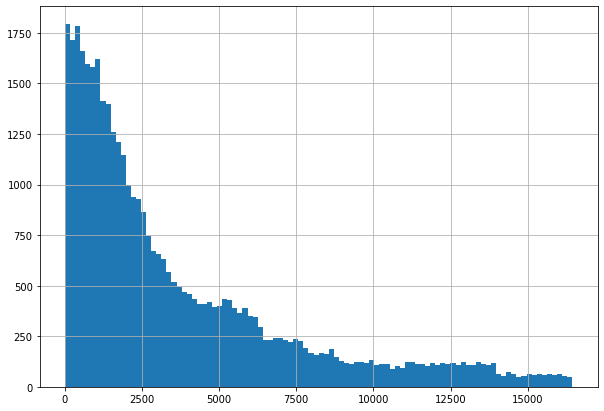

In [41]:
plt.rcParams['figure.figsize'] = (10, 7)
df_train['Ranking'].hist(bins=100)

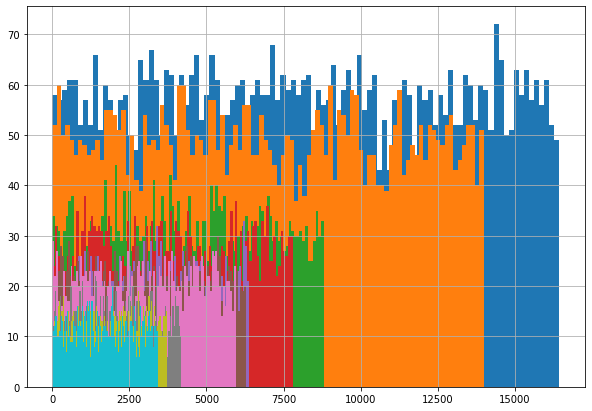

In [42]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

### Посмотрим распределение целевой переменной

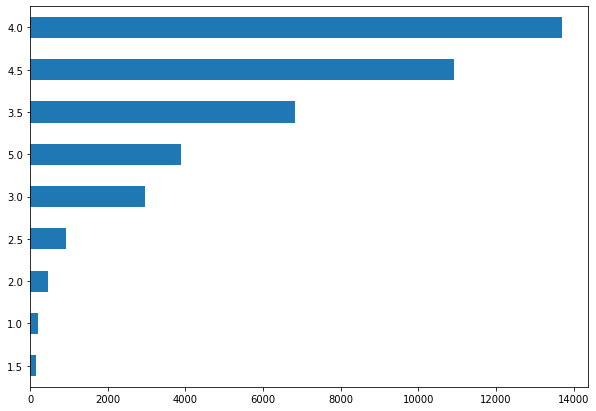

In [43]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

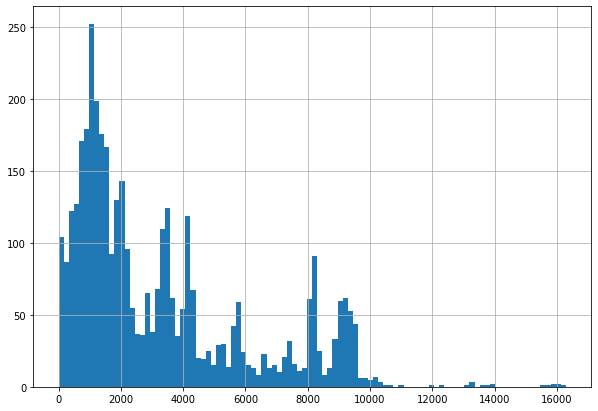

In [44]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

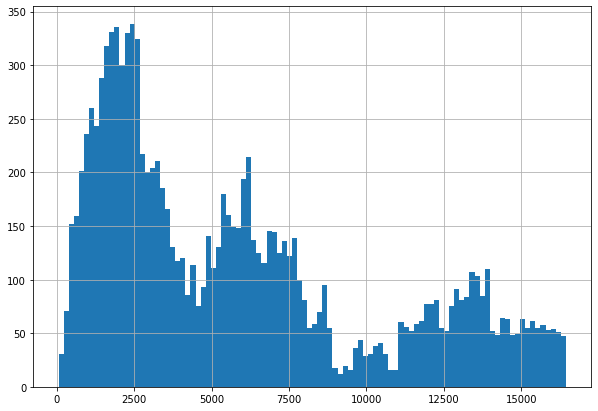

In [45]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### Корреляция признаков

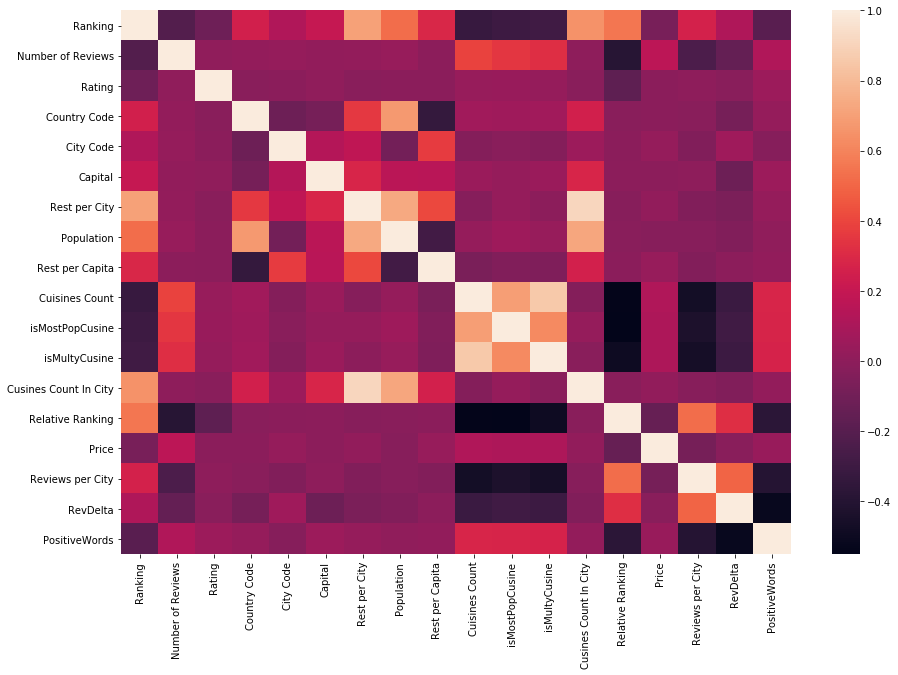

In [46]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Из графика видно, что корреляция между Rating и нашими переменными стала больше vs baseline (цвет диаграммы в разы светлее, что говорит о более высокой степени корреляции), а также о том, что она носит в основном положительный характер, хотя есть и переменные с негативной корреляцией между друг другом.

# Data Processing

In [47]:
# Убираем не нужные для модели признаки (мы их знаем из нашего исследования выше - те, что не несут нагрузки и уже были нами заменены числовыми форматами)
data.drop(['Restaurant_id', 'URL_TA', 'ID_TA', 'City',
           'Cuisine Style', 'Reviews', 'Country'], axis=1, inplace=True)

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ranking                50000 non-null  float64
 1   Number of Reviews      50000 non-null  float64
 2   sample                 50000 non-null  int64  
 3   Rating                 50000 non-null  float64
 4   Country Code           50000 non-null  int32  
 5   City Code              50000 non-null  int32  
 6   Capital                50000 non-null  int64  
 7   Rest per City          50000 non-null  int64  
 8   Population             50000 non-null  int64  
 9   Rest per Capita        50000 non-null  float64
 10  Cuisines Count         50000 non-null  int64  
 11  isMostPopCusine        50000 non-null  int64  
 12  isMultyCusine          50000 non-null  int64  
 13  Cusines Count In City  50000 non-null  int64  
 14  Relative Ranking       50000 non-null  float64
 15  Pr

In [49]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values  # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Разделим данные на еще один тест и трейн, для валидации. Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [50]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [51]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 18), (40000, 18), (40000, 17), (32000, 17), (8000, 17))

# Model 

In [52]:
# Создаём модель
model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [53]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [54]:
y_pred = round_of_rating(y_pred)  # округлим рейтинг

In [55]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1775


Ура! Получилось лучше, чем в baseline :) Но есть еще куда стремиться)

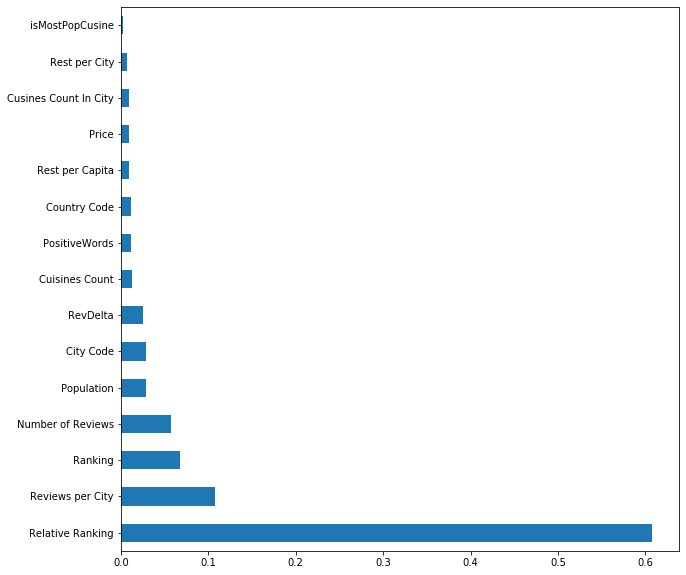

In [56]:
# в RandomForestRegressor выводим важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Готовим Submission на кагл

In [57]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,Country Code,City Code,Capital,Rest per City,Population,Rest per Capita,Cuisines Count,isMostPopCusine,isMultyCusine,Cusines Count In City,Relative Ranking,Price,Reviews per City,RevDelta,PositiveWords
368,12313.0,133.0,0.0,22,16,1,7193,8908081,0.000807,1,0,0,111,1.711803,1.000000,66,86,1.0
3670,8850.0,59.0,0.0,5,24,1,6108,2148271,0.002843,2,0,0,103,1.448919,1.000000,175,99,3.0
8205,2523.0,3.0,0.0,2,25,1,1816,1305737,0.001391,1,0,0,83,1.389317,0.815129,2042,0,1.0
9,605.0,13.0,0.0,20,27,1,1033,975904,0.001059,1,0,0,78,0.585673,0.815129,691,34,2.0
8246,1644.0,74.0,0.0,5,18,0,1126,1719268,0.000655,2,0,0,74,1.460036,1.000000,139,3650,0.0
1139,1688.0,11.0,0.0,12,0,1,1372,1148972,0.001194,1,0,0,86,1.230321,0.815129,807,14,3.0
8294,12794.0,20.0,0.0,5,24,1,6108,2148271,0.002843,1,0,0,103,2.094630,0.815129,485,0,3.0
4640,868.0,17.0,0.0,21,30,0,685,1395356,0.000491,6,1,1,78,1.267153,0.000000,560,377,2.0
615,132.0,47.0,0.0,5,18,0,1126,1719268,0.000655,1,0,0,74,0.117229,0.815129,188,0,1.0
3933,245.0,261.0,0.0,0,28,1,1443,1929944,0.000748,6,1,1,90,0.169785,1.000000,31,117,1.0


In [58]:
test_data = test_data.drop(['Rating'], axis=1)

In [59]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [60]:
predict_submission = round_of_rating(model.predict(test_data))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [61]:
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4. , 4.5])

In [62]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5
